# Data Cleaning and Feature Engineering

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set styling
plt.style.use('fivethirtyeight')
sns.set_palette('deep')

In [3]:
# add sys path to import from src directory
import sys
sys.path.append('..')

In [4]:
# import function from src modules
from src.data_preprocessing import load_data, check_missing_values
from src.feature_engineering import handle_missing_values, create_new_features, encode_categorical_features

In [5]:
# load data
train, test = load_data('../data/train.csv', '../data/test.csv')

Loaded train data: (1460, 81) rows, 81 columns
Loaded test data: (1459, 80) rows, 80 columns


## Identifying and Handling Outliers

In [8]:
# load outlier indices identified in EDA
try:
    with open('../data/outlier_indices.json', 'r') as f:
        outlier_data = json.load(f)
        outlier_indices = outlier_data['outlier_indices']
    print(f"Loaded {len(outlier_indices)} outlier indices")
except FileNotFoundError:
    print("No outlier indices file found.")

Loaded 2 outlier indices


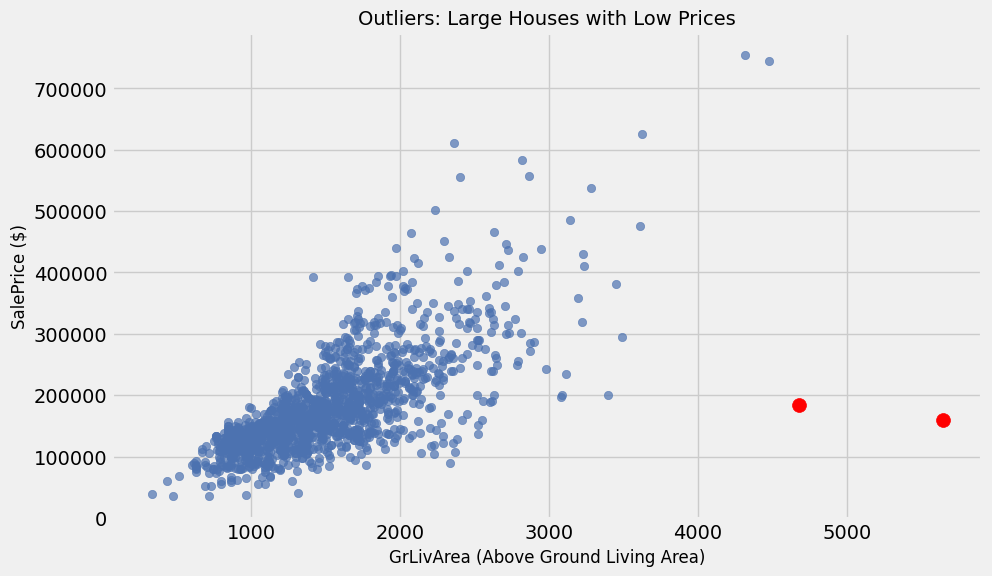

Before outlier removal: (1460, 81)
After outlier removal (1458, 81)


In [9]:
# visualize those outliers if any were found
if outlier_indices:
    plt.figure(figsize=(10, 6))
    plt.scatter(train['GrLivArea'], train['SalePrice'], alpha=0.7)
    plt.scatter(train.loc[outlier_indices, 'GrLivArea'],
                train.loc[outlier_indices, 'SalePrice'],
                color='red', s=100)
    plt.xlabel('GrLivArea (Above Ground Living Area)', fontsize=12)
    plt.ylabel('SalePrice ($)', fontsize=12)
    plt.title('Outliers: Large Houses with Low Prices', fontsize=14)
    plt.show()

    # remove outliers from training set
    print("Before outlier removal:", train.shape)
    train = train.drop(outlier_indices)
    print("After outlier removal", train.shape)
else:
    print("No outliers to remove")

In [10]:
# save target and IDs before combining datasets
target = train['SalePrice'].copy()
train_ID = train['Id'].copy()
test_ID = test['Id'].copy()

## Data Preparation for Feature Engineering

In [11]:
# combine train and test data for consistent preprocessing
all_data = pd.concat([train.drop(['Id', 'SalePrice'], axis=1),
                      test.drop(['Id'], axis=1)])
print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2917, 79)


In [12]:
# check for missing values
missing_values = check_missing_values(all_data)
print(f"Features with missing values: {len(missing_values)}")
print(missing_values.head(10))

Features with missing values: 34
              Missing Values  Percentage
PoolQC                  2908   99.691464
MiscFeature             2812   96.400411
Alley                   2719   93.212204
Fence                   2346   80.425094
MasVnrType              1766   60.541652
FireplaceQu             1420   48.680151
LotFrontage              486   16.660953
GarageFinish             159    5.450806
GarageQual               159    5.450806
GarageCond               159    5.450806


## Handling Missing Values

In [13]:
# apply missing value handling
all_data = handle_missing_values(all_data)

In [14]:
# verify missing values were handled properly
missing_after = check_missing_values(all_data)
if len(missing_after) > 0:
    print("Remaining missing values:")
    print(missing_after)
else:
    print("All missing values have been handled")

All missing values have been handled


## Feature Engineering - Creating New Features

In [15]:
# add new features
all_data = create_new_features(all_data)

In [16]:
# display new features
print("New features added:")
new_features = ['TotalSF', 'TotalBathrooms', 'Age', 'YearsSinceRemodel', 
                'Remodeled', 'IsNew', 'HasPool', 'HasGarage', 'HasFireplace', 
                'HasBasement', 'TotalPorchSF', 'QualXArea', 'QualXAge',
                'OverallQual2', 'GrLivArea2', 'TotalSF2']
for feature in new_features:
    if feature in all_data.columns:
        print(f"{feature}: {all_data[feature].dtype}")

New features added:
TotalSF: float64
TotalBathrooms: float64
Age: int64
YearsSinceRemodel: int64
Remodeled: int64
IsNew: int64
HasPool: int64
HasGarage: int64
HasFireplace: int64
HasBasement: int64
TotalPorchSF: int64
QualXArea: int64
QualXAge: int64
OverallQual2: int64
GrLivArea2: int64
TotalSF2: float64


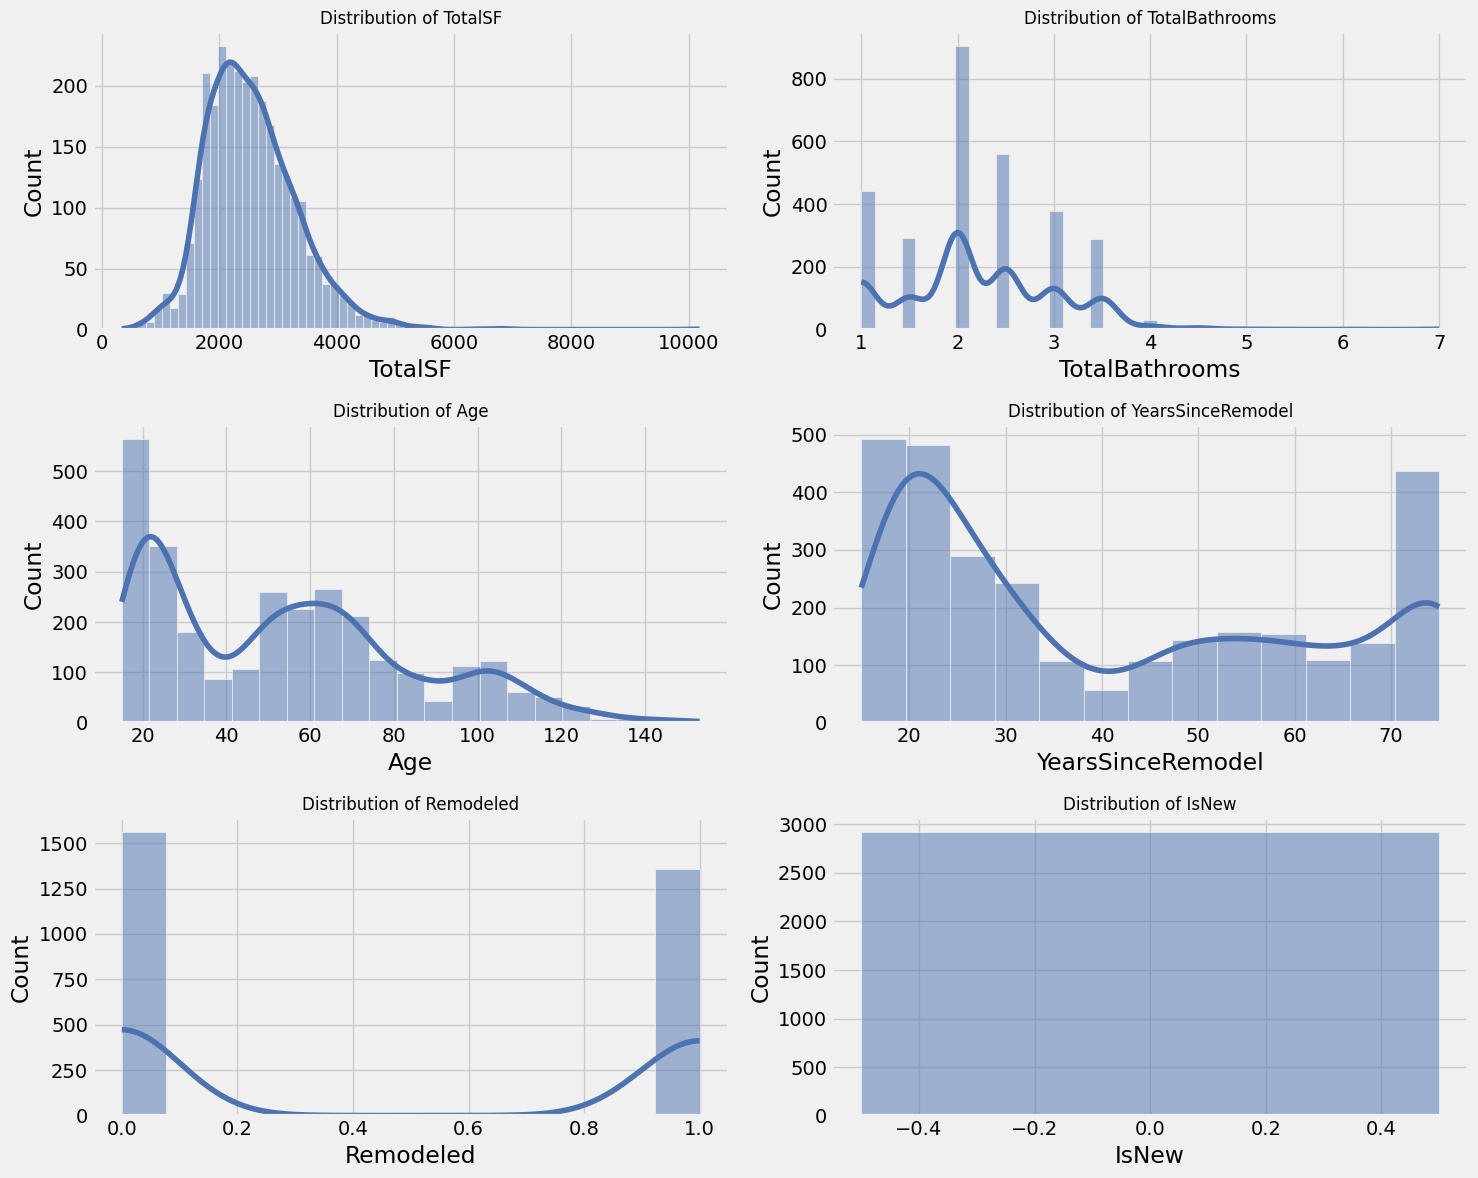

In [17]:
# visualize distributions of new features
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature, in enumerate(new_features[:6]):
    if feature in all_data.columns:
        sns.histplot(all_data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}', fontsize=12)

plt.tight_layout()
plt.show()

## Transforming Skewed Features

In [18]:
# check for skewed numerical features
numeric_features = all_data.select_dtypes(include=[np.number]).columns
skewed_features = all_data[numeric_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]

print(f"Skewed numerical features ({len(high_skew)}):")
print(high_skew.head(10))

Skewed numerical features (37):
MiscVal         21.939672
PoolQC          19.548879
PoolArea        17.688664
HasPool         15.494756
LotArea         13.109495
LowQualFinSF    12.084539
3SsnPorch       11.372080
TotalSF2         4.405359
KitchenAbvGr     4.300550
BsmtFinSF2       4.144503
dtype: float64


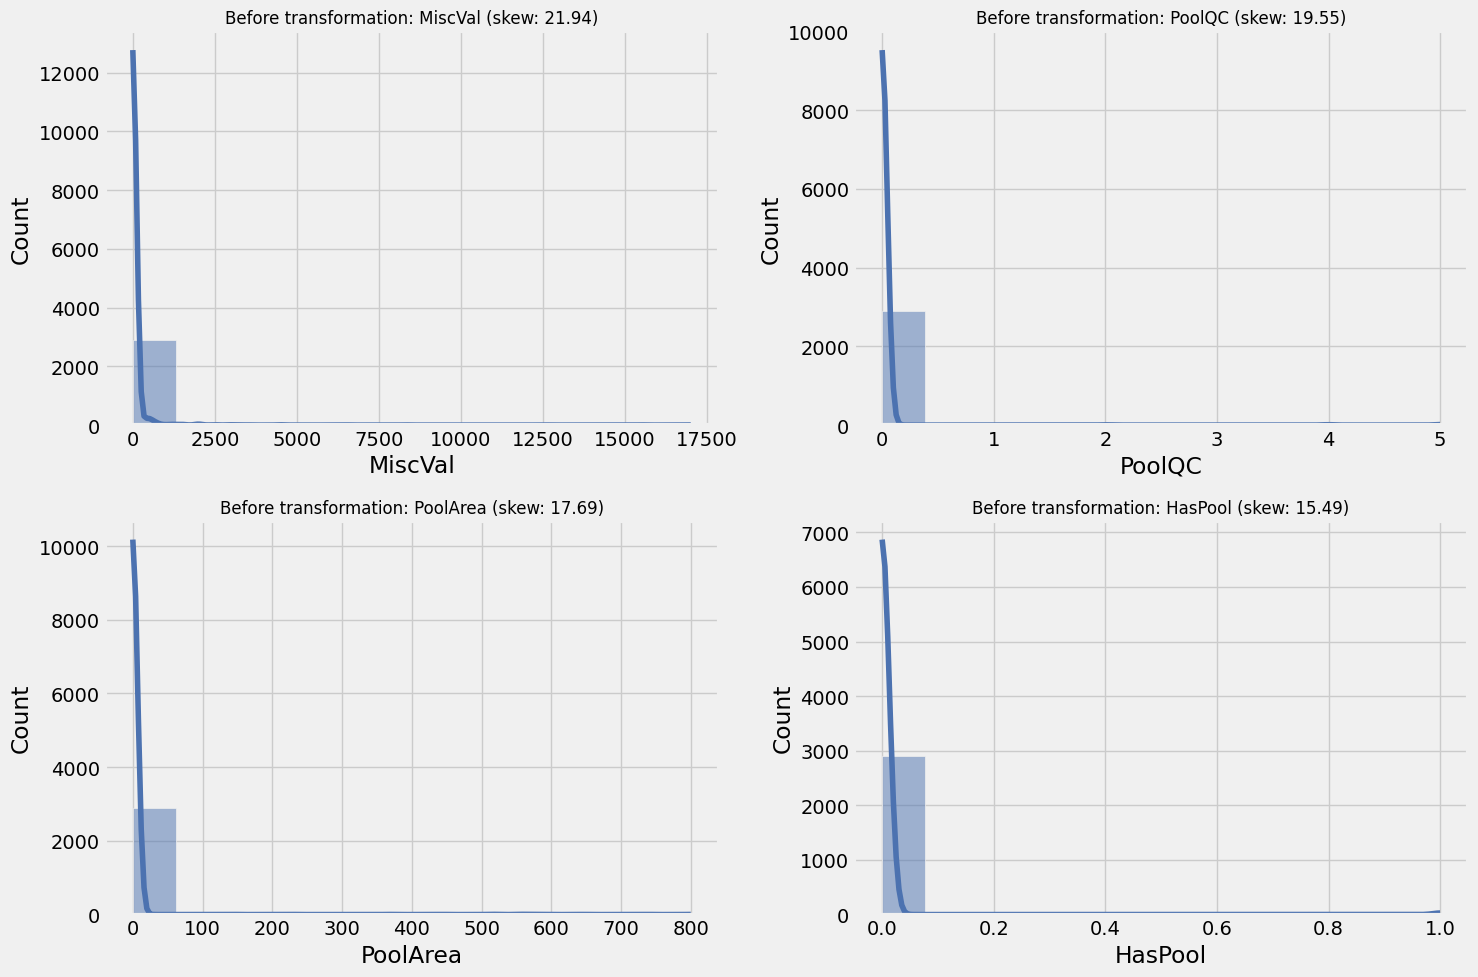

In [19]:
# plot some of the most skewed features before transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(high_skew.index[:4]):
    sns.histplot(all_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Before transformation: {feature} (skew: {skewed_features[feature]:.2f})', fontsize=12)

plt.tight_layout()
plt.show()

In [20]:
# apply log transformation to skewed features
for feature in high_skew.index:
    all_data[feature] = np.log1p(all_data[feature])

In [21]:
# verify transformation effect
after_transform_skew = all_data[high_skew.index].apply(lambda x: stats.skew(x))
print("Skewness after transformation:")
print(after_transform_skew.head(10))

Skewness after transformation:
MiscVal          5.212005
PoolQC          18.575874
PoolArea        15.623275
HasPool         15.494756
LotArea         -0.532646
LowQualFinSF     8.554639
3SsnPorch        8.822116
TotalSF2        -0.430327
KitchenAbvGr     3.518883
BsmtFinSF2       2.461259
dtype: float64


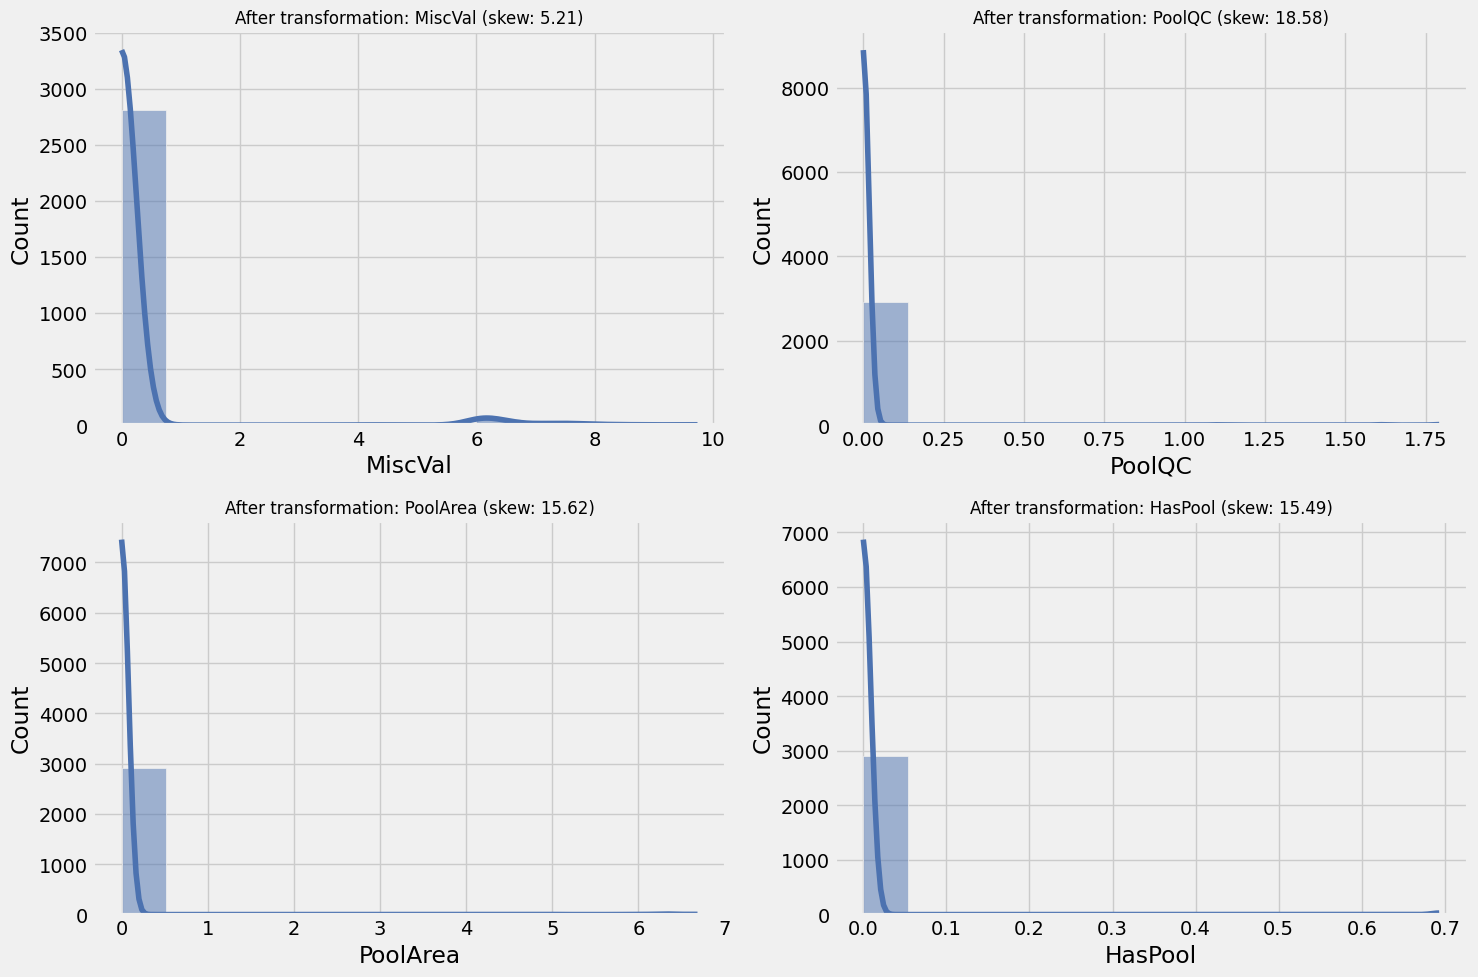

In [22]:
# plot the same features after transformation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(high_skew.index[:4]):
    sns.histplot(all_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'After transformation: {feature} (skew: {after_transform_skew[feature]:.2f})', fontsize=12)

plt.tight_layout()
plt.show()

## Categorical Feature Encoding

In [23]:
# prepare categorical features for encoding
categorical_features = all_data.select_dtypes(include=['object']).columns
print(f"Categorical features to encode ({len(categorical_features)}):")
print(list(categorical_features))

Categorical features to encode (34):
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [24]:
# encode categorical features
all_data = encode_categorical_features(all_data)

One-hot encoding 34 categorical features


In [25]:
# check the dimensionality after encoding
print(f"Data shape after categorical encoding: {all_data.shape}")

Data shape after categorical encoding: (2917, 258)


## Final Data Preparation

In [26]:
# split the processed data back into train and test sets
n_train = train.shape[0]
train_processed = all_data[:n_train]
test_processed = all_data[n_train:]

In [27]:
# add the target variable to the processed training data
train_processed['SalePrice'] = target

In [28]:
# apply log transformation to the target (SalePrice) as it was skewed
train_processed['SalePrice_Log'] = np.log1p(train_processed['SalePrice'])

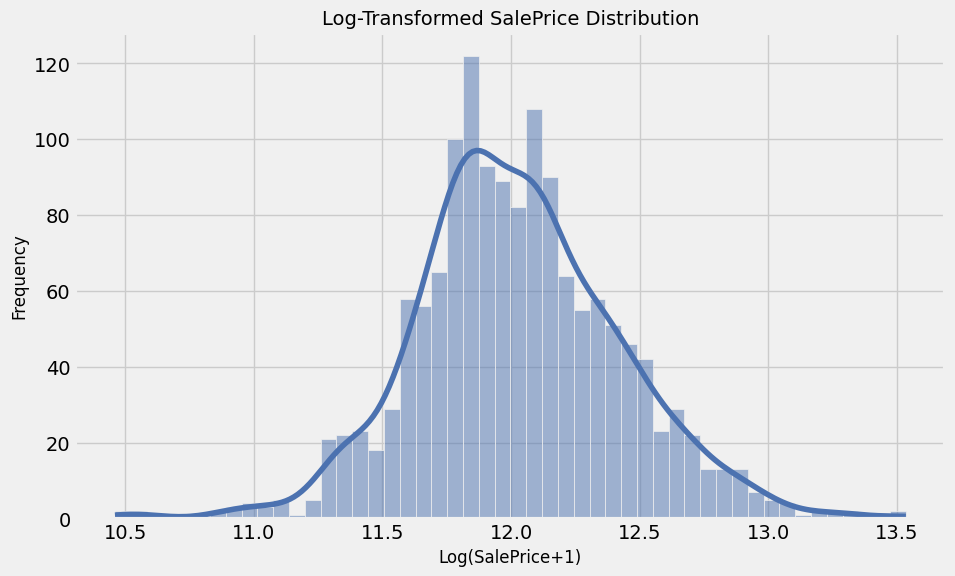

In [29]:
# visualize the transformed target
plt.figure(figsize=(10, 6))
sns.histplot(train_processed['SalePrice_Log'], kde=True, bins=50)
plt.title("Log-Transformed SalePrice Distribution", fontsize=14)
plt.xlabel("Log(SalePrice+1)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

## Save Processed Data

In [30]:
# save processed data for modeling
train_processed.to_csv('../data/train_processed.csv', index=False)
test_processed.to_csv('../data/test_processed.csv', index=False)

print("Processed data saved to ../data/ directory")
print(f"Processed training data shape: {train_processed.shape}")
print(f"Processed test data.shape: {test_processed.shape}")

Processed data saved to ../data/ directory
Processed training data shape: (1458, 260)
Processed test data.shape: (1459, 258)


## Feature Engineering Summary

We have:

1. Removed outliers identified in EDA
2. Handled missing values with appropriate strategies
3. Created new features to capture important housing characteristics
4. Transformed skewed numerical features to improve model performance
5. Encoded categorical features for use in modeling
6. Applied log transformation to the target variable
7. Saved the processed data for modeling